## Latent Dirichlet Allocation

### Import data

In [1]:
import json

with open('preprocessing/data.json', 'r') as f:
    documents = json.load(f)
    texts = [' '.join([word for word in text]) for text in documents]

### Create dictionary and corpus

In [2]:
from gensim import corpora

# Map each token to a unique ID
dictionary = corpora.Dictionary(documents)
print(f'Number of unique tokens: {len(dictionary)}')

# Filter out tokens by frequency
min_doc, max_doc = 15, .3
dictionary.filter_extremes(no_below=min_doc, no_above=max_doc)
print(f'Number of unique tokens (filtered): {len(dictionary)}')

# Create a BOW corpus
corpus = [dictionary.doc2bow(doc) for doc in documents]
print(f'Number of documents: {len(corpus)}')

Number of unique tokens: 43392
Number of unique tokens (filtered): 5034
Number of documents: 2289


### Run the LDA model

In [3]:
from gensim.models import LdaModel
from gensim.test.utils import datapath

tmp = datapath('/tmp/model.ldamodel')

# Set training parameters for LDA
num_topics = 15
random_state = 100
chunksize = len(corpus)
passes = 150
alpha = .9099999999999999
eta = .9099999999999999
iterations = 100
eval_every = 5

In [4]:
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, \
                     random_state=random_state, chunksize=chunksize, \
                     passes=passes, alpha=alpha, eta=eta, iterations=iterations, \
                     eval_every=eval_every)

In [5]:
# Save the model
lda_model.save(tmp)

In [6]:
# Load the model
lda_model = LdaModel.load(tmp)

### Print the results

In [5]:
from pprint import pprint

top_topics = lda_model.top_topics(corpus)
pprint(lda_model.print_topics(num_words=15))

[(0,
  '0.027*"мышь" + 0.024*"нейрон" + 0.014*"мозг" + 0.014*"опухоль" + '
  '0.012*"белок" + 0.012*"рецептор" + 0.012*"ткань" + 0.009*"рак" + '
  '0.008*"нервный" + 0.007*"активность" + 0.007*"сигнал" + 0.007*"кровь" + '
  '0.006*"заболевание" + 0.006*"экспрессия" + 0.006*"раковый"'),
 (1,
  '0.025*"самец" + 0.024*"птица" + 0.022*"поведение" + 0.020*"самка" + '
  '0.012*"сигнал" + 0.012*"песня" + 0.012*"особь" + 0.010*"муравей" + '
  '0.009*"гнездо" + 0.008*"социальный" + 0.007*"звук" + 0.007*"колония" + '
  '0.006*"обучение" + 0.006*"птенец" + 0.005*"яйцо"'),
 (2,
  '0.034*"самка" + 0.031*"самец" + 0.025*"популяция" + 0.022*"отбор" + '
  '0.018*"мутация" + 0.017*"половой" + 0.012*"особь" + 0.010*"пол" + '
  '0.010*"потомство" + 0.009*"размножение" + 0.009*"приспособленность" + '
  '0.008*"эволюционный" + 0.008*"линия" + 0.008*"генетический" + '
  '0.008*"поколение"'),
 (3,
  '0.022*"галактика" + 0.019*"звезда" + 0.016*"масса" + 0.013*"излучение" + '
  '0.010*"волна" + 0.010*"чёрный_д

### Evaluate topic coherence

In [6]:
from gensim.models import CoherenceModel

# Compute perplexity
print(f'Perplexity:', lda_model.log_perplexity(corpus)) # the lower the better

# Compute coherence score using CV
coherence_c_v_model = CoherenceModel(model=lda_model, texts=documents, 
                                     dictionary=dictionary, coherence='c_v')
coherence_c_v = coherence_c_v_model.get_coherence()
print(f'Coherence score (c_v): {coherence_c_v}') # 0.5 is good, 0.6 is excellent

# Compute coherence score using UMass
coherence_umass_model = CoherenceModel(model=lda_model, texts=documents, 
                                       dictionary=dictionary, coherence="u_mass")
coherence_umass = coherence_umass_model.get_coherence()
print(f'Coherence score (UMass): {coherence_umass}') # should be close to 0

Perplexity: -7.214766367578802
Coherence score (c_v): 0.6975279439314526
Coherence score (UMass): -1.4119207608322992


### Visualize the topics

In [7]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
lda_display = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

C:\Users\satan\AppData\Roaming\Python\Python39\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


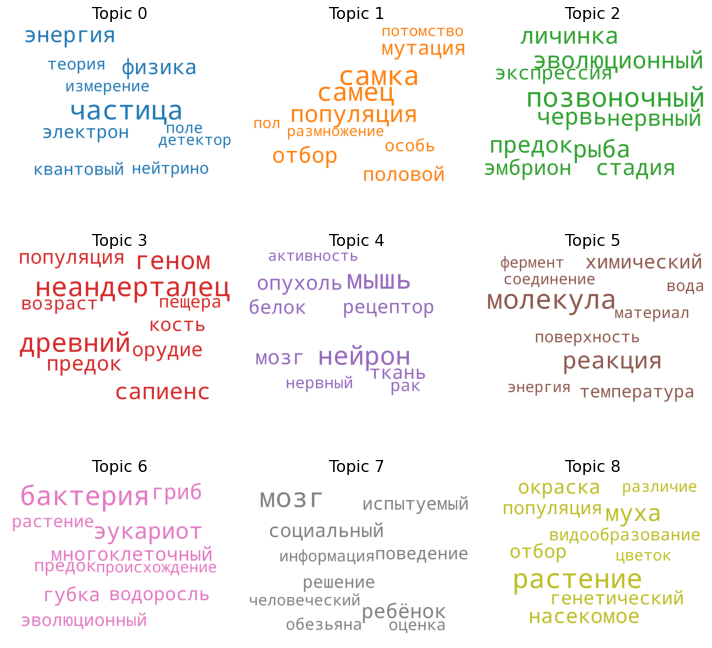

In [8]:
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
from wordcloud import WordCloud

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()] # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(background_color='white', width=2500, height=1800, max_words=10,
                  colormap='tab10', color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### Select the optimal number of topics

In [9]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [10]:
from gensim.models import CoherenceModel

model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, \
                                                        texts=documents, start=2, limit=40, step=6)

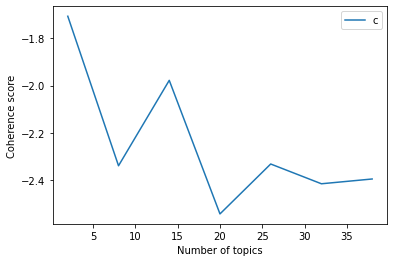

In [11]:
from matplotlib import pyplot as plt

# Show graph
limit, start, step = 40, 2, 6
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Extract the dominant topic for each document

In [48]:
import pandas as pd

def format_topics_sentences(lda_model=None, corpus=corpus, texts=documents):
    sent_topics_df = pd.DataFrame()
    
    # Get main topic in each document
    for i, row_list in enumerate(lda_model[corpus]):
        row = row_list[0] if lda_model.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j != 0: continue
            else:
                wp = lda_model.show_topic(topic_num)
                topic_keywords = ', '.join([word for word, prop in wp])
                sent_topics_df = pd.concat([sent_topics_df, pd.Series([int(topic_num), round(prop_topic, 4), \
                                                                       topic_keywords]).to_frame().T], ignore_index=True)

    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(lda_model=lda_model, corpus=corpus, texts=documents)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3,0.8539,"галактика, звезда, масса, излучение, волна, чё...","[апрель, год, коллаборация, телескоп, горизонт..."
1,1,3,0.8885,"галактика, звезда, масса, излучение, волна, чё...","[быстрый, радиовсплеск, год, пора, астрофизик,..."
2,2,11,0.9792,"молекула, реакция, химический, температура, по...","[долгий, время, реакция, циклоприсоединение, р..."
3,3,11,0.7425,"молекула, реакция, химический, температура, по...","[учёный, чехия, франция, помощь, метод, трёхме..."
4,4,0,0.5784,"мышь, нейрон, мозг, опухоль, белок, рецептор, ...","[клетка, друг, друг, помощь, химический, сигна..."
...,...,...,...,...,...
2284,2284,14,0.7202,"позвоночный, рыба, эволюционный, личинка, черв...","[головоногий, моллюск, наутилус, глаз, похожий..."
2285,2285,10,0.7566,"бактерия, эукариот, гриб, многоклеточный, губк...","[мезомицетозой, открытый, одноклеточный, родст..."
2286,2286,14,0.8958,"позвоночный, рыба, эволюционный, личинка, черв...","[современный, биология, исследование, ген, сем..."
2287,2287,14,0.799,"позвоночный, рыба, эволюционный, личинка, черв...","[бесчелюстной, древний, группа, позвоночный, ж..."


### Show frequency distribution of word counts in documents

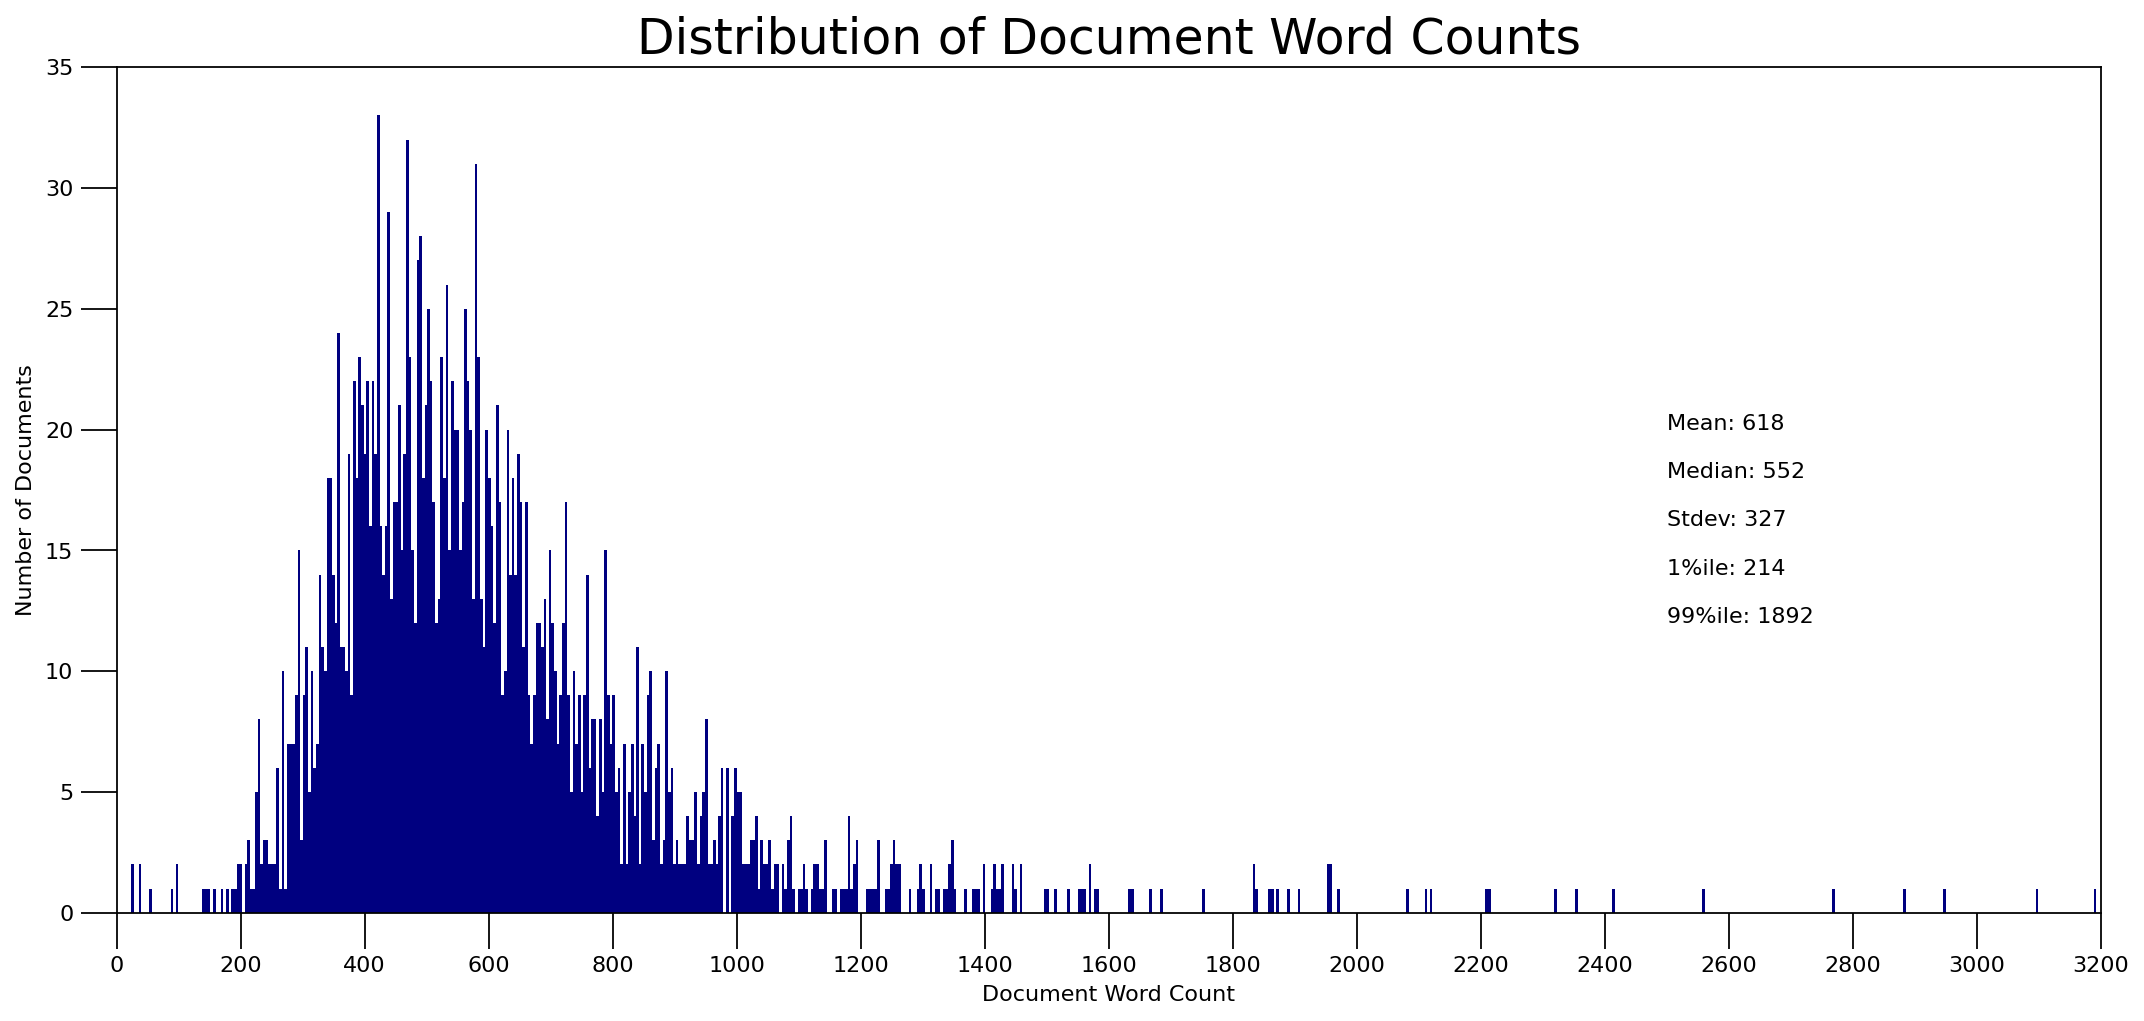

In [68]:
import matplotlib.pyplot as plt
import numpy as np

doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins=1000, color='navy')
plt.text(2500, 20, "Mean: " + str(round(np.mean(doc_lens))))
plt.text(2500, 18, "Median: " + str(round(np.median(doc_lens))))
plt.text(2500, 16, "Stdev: " + str(round(np.std(doc_lens))))
plt.text(2500, 14, "1%ile: " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(2500, 12, "99%ile: " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.yticks(np.arange(0, 40, 5))
plt.xticks(np.arange(0, 3300, 200))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()